Uncomment this cell to run the notebook with TPUs 👇🏻

In [1]:
TPU_ENVIRON=False # find out the way to detect it 
# %%capture
if TPU_ENVIRON:
    !pip install --upgrade torch==1.13 numpy pandas fastai timm wandb torchmetrics pytorch-lightning lightning-utilities albumentations wandb opencv-python typing-extensions==4.3.0 torchtext torchvision tensorboard tensorflow
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version 1.13 --apt-packages libomp5 libopenblas-dev

    # local imports to keep things neat
    import sys
    import importlib
    import typing_extensions
    import tensorboard
    importlib.reload(typing_extensions)
    importlib.reload(tensorboard)
    import pytorch_lightning as pl
    pl.loggers.tensorboard_TENSORBOARD_AVAILABLE = True


Each TPU core uses two-dimensional 8 X 128 vector registers for processing matrix multiplications. In general, your batch size should be evenly divisible by 8 or 128.

In [2]:
!nvidia-smi

Sat Jan 21 22:06:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Environment/Dataset configuration

## TLDR
`kaggle.json` - Kaggle API key

wandb - if enabled enter api key in notebook (need to change - troublesome)

## Details
Basicaly 3 options:
* Kaggle environement
* Google colab environment
* Other

When running on kaggle, kaggle datasets are available since runtime is ready.
Otherwise one have to download dataset - downloading from Kaggle is good option.
**In order to download kaggle dataset one need his own API key**


Original Kaggle DICOM dataset ~300GB needs preprocessing.
`kaggle competitions download -c rsna-breast-cancer-detection`

Currently I use community-processed or self-processed training data.
Kaggle supports creating own private datasets up to 20GB each one.

In [3]:
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except ImportError:
    IS_KAGGLE = False

In [4]:
import os
import os.path
from pathlib import Path

In [5]:
DATASET_URI = "awsaf49/rsna-bcd-roi-1024x512-png-v2-dataset"
DATASET_PATH_SUFFIX = ""
DATASET_DIR = os.path.split(DATASET_URI)[1]
DATASETS_LOCAL_REPO = "/kaggle/input/" if IS_KAGGLE else os.path.expanduser("~/rsna-breast")
DATASET_PATH_START = os.path.join(DATASETS_LOCAL_REPO, DATASET_DIR)
DATASET_PATH = os.path.join(DATASET_PATH_START, DATASET_PATH_SUFFIX)

In [6]:
# TODO add wandb api key
try:
    from google.colab import files
    if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
        files.upload()
        #2. Series of commands to set-up for download
        !ls -lha kaggle.json
        !mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
        !cp kaggle.json ~/.kaggle/ # move the key to the folder
        #3. giving rw access (if 401-nathorized)
        !chmod 600 ~/.kaggle/kaggle.json
except ImportError:
    pass
if not IS_KAGGLE:
    !pip install -q kaggle # installing the kaggle package
    if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.path.exists("kaggle.json"):
        !mkdir -p ~/kaggle/
        !cp kaggle.json ~/.kaggle/ # move the key to the folder
        #3. giving rw access (if 401-nathorized)
        !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d {DATASET_URI} -p {DATASETS_LOCAL_REPO}
    !unzip -q {DATASET_PATH_START}.zip -d {DATASET_PATH_START}
    !rm {DATASET_PATH_START}.zip

## Installation and Imports

In [7]:
# %%capture
if not TPU_ENVIRON:
    !pip install --upgrade timm wandb torchmetrics pytorch-lightning albumentations wandb opencv-python typing-extensions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.21
    Uninstalling wandb-0.12.21:
      Successfully uninstalled wandb-0.12.21
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.8.6
    Uninstalling pytorch-lightning-1.8.6

In [8]:
import os
from pathlib import Path
import sys
import cv2
import glob
import numpy as np
import pandas as pd
import math
import enum
import matplotlib.pyplot as plt
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

import wandb

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler

import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

import sklearn.model_selection

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, Affine
)
import albumentations.augmentations.transforms
from albumentations.pytorch import ToTensorV2

# import warnings
# warnings.simplefilter('ignore')


## Config File and Wandb

In [9]:
class WandbMode:
    OFFLINE = "offline"
    ONLINE = "online"
    DISABLED = "disabled"
    
class WandbConfig:
    # change to disabled/offline if not needed
    mode = WandbMode.ONLINE
    project = "rsna-breast"
    name = None
    save_dir = None
    log_model = "all"

class ModelCheckpointSource(str, enum.Enum):
    NO_CHECKPOINT="no_checkpoint"
    WANDB="wandb"
    LOCAL="local"

class Config:
    train_bs=16 if not TPU_ENVIRON else 1024
    valid_bs=16 if not TPU_ENVIRON else 1024
    model_name="tf_efficientnetv2_m"
    model_params = {
      "drop_rate": 0.2,
      "drop_path_rate": 0.2
    }
    
    model_checkpoint_source = ModelCheckpointSource.NO_CHECKPOINT
    model_checkpoint_uri = "checkpoints/last-v1.ckpt"
    # True, to use Config params instead of checkpoints
    overwrite_checkpoint_hparams=True
    
    #train_imgs_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/train_images_processed_cv2_256"
    #train_imgs_path = "/kaggle/input/rsna-breast-png-roi/train_images/512/"
    #train_imgs_path = "/kaggle/input/rsna-cut-off-empty-space-from-images"
    #train_imgs_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_512/train_images_processed_cv2_vl_512"
    
    train_imgs_path = f"{DATASET_PATH}/train_images"
    
    # True if image data folders have structure <patient_id>/<image_id>.png
    # False if image data have structure <patient_id>_<image_id>.png
    data_has_patient_folder_sturcture = True
    
    # MADE error in my dataset  - need to use kaggles
    #train_csv_path = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
    train_csv_path = f"{DATASET_PATH}/train.csv"
    
    test_imgs_path = f"{DATASET_PATH}/test_images/"
    
    accelerator="auto"   # auto, gpu or cpu
    # TODO - parallel computations
    num_devices=1 if not TPU_ENVIRON else 8   

    resize_aspect_ratio = 0.5
    use_pretrained=True
    epochs_count = 10
    splits_count = 1
    warmup_lr = 1e-6
    warmup_epochs = 3
    lr=1e-4
    t_max= 4
    min_lr= 1e-5
    weight_decay=1e-5
    # weight of cancer examples in loss function
    pos_weight = 1
    # upsample cancers to percent
    positive_upsample_to_percent = 0.12
    # mixed-precision
    precision=16 if torch.cuda.is_available() else 32 
    
    # dataloaders
    dataloader_workers_count = 4 if not TPU_ENVIRON else 64  
    # aux_targets = ['BIRADS'] # not used
    
    debug=False
    debug_data_use_only_percent=0.001
    

def config_class_to_dict(config_class):
    # add recursion if needed
    return { k:v for k,v in Config.__dict__.items() if not k.startswith("__") }

In [10]:
print(Config.train_imgs_path)
print(Path(Config.train_imgs_path).exists())

/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dataset//train_images
True


In [11]:
wandb_logger = None
wandb_artifact = None
wandb_artifact_dir = None
if WandbConfig.mode != WandbMode.DISABLED:
    wb_key = None
    if IS_KAGGLE:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        wb_key = user_secrets.get_secret("WANDB_API_KEY")
    else:
        wb_key = os.environ.get("WANDB_API_KEY")
    # wandb should get key fron environment
    wandb.login(key=wb_key)

    wandb_logger = WandbLogger(
        project=WandbConfig.project,
        name = WandbConfig.name,
        offline = True if WandbConfig.mode == WandbMode.OFFLINE else False,
        save_dir = WandbConfig.save_dir,
        log_model = WandbConfig.log_model,
        group='vision',
        job_type='train',
        config=config_class_to_dict(Config)
    )


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:320: UserWarning: Providing log_model=all requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
  f"Providing log_model={log_model} requires wandb version >= 0.10.22"
wandb: Currently logged in as: michal-kurtys. Use `wandb login --relogin` to force relogin


In [12]:
checkpoint_path = None
if Config.model_checkpoint_source==ModelCheckpointSource.LOCAL:
    checkpoint_path = Path(Config.model_checkpoint_uri)
if WandbConfig.mode == WandbMode.ONLINE and Config.model_checkpoint_source==ModelCheckpointSource.WANDB:
    artifact = wandb.run.use_artifact(
        Config.model_checkpoint_uri, type="model")
    artifact_dir = artifact.download()
    checkpoint_path = Path(artifact_dir) / "model.ckpt"

In [13]:
# not used, but efficientnet v2 do not use weight decay
# for some parameters
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [14]:
def create_test_opt_and_scheduler():
    opt = torch.optim.SGD([torch.tensor(1)], lr=Config.lr)
    scheduler1 = torch.optim.lr_scheduler.ConstantLR(opt,
                                                     factor=Config.warmup_lr/Config.lr,
                                                     total_iters=20)
    scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
                opt, 
                T_max=Config.t_max,
                eta_min=Config.min_lr
                )
    scheduler = torch.optim.lr_scheduler.SequentialLR(opt,
                                                      schedulers=[scheduler1, scheduler2],
                                                      milestones=[Config.warmup_epochs])
    return opt, scheduler

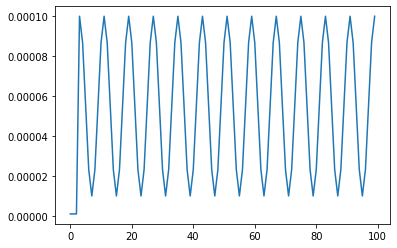

In [15]:


def visualise_scheduler(opt, scheduler, steps=Config.epochs_count, lr=1):
    lrs = []
    for _ in range(100):
        opt.step()
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    
    fig, ax = plt.subplots()
    ax.plot(lrs)
    fig.show()
opt, scheduler = create_test_opt_and_scheduler()
visualise_scheduler(opt,
                    scheduler)

In [16]:
def probabilistic_f1(labels, preds, beta=1):
    """
    Function taken from Awsaf's notebook:
    https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train
    """
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

## Dataset Class - for loading in data

In [17]:
def display_batch(batch, figsize=(16,10), n_cols=2, maximgs=None, cmap="bone"):
    if isinstance(batch, tuple) or isinstance(batch, list):
        if len(batch) == 2:
            imgs, targets = batch
        else:
            imgs, targets, filenames = batch
    else:
        imgs = batch
        targets = None
    #targets = targets.numpy().squeeze()
    
    n = imgs.shape[0] if not maximgs else min(imgs.shape[0], maximgs)
    n_rows = math.ceil(n / n_cols)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for i in range(n):
        x = i % n_cols
        y = i // n_cols
        ax=axs[y,x]
        im = imgs[i, :, :, :].squeeze()
        im = im.numpy().transpose((1,2,0)).squeeze()
        ax.imshow(im, cmap=cmap)
        if targets is not None:
            ax.set_title(f'Target {targets[i]}', fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    fig.show() 

In [18]:
def pad_images_to_max_dim(batch, pad_value = -1):
    "Pad images with values if there are images of different size in batch"
    # consider non-symmetrical padding
    
    # print([img.shape for img in batch])
    max_h = max([img.shape[-2] for img in batch])
    max_w = max([img.shape[-1] for img in batch])
    # pad all images in batch
    padded_batch = []
    for i, img in enumerate(batch):
        pad_left, pad_right, pad_top, pad_bottom = 0, 0, 0, 0
        diff_w = max_w - img.shape[-1]
        diff_h = max_h - img.shape[-2]
        if diff_w > 0:
            pad_left = diff_w//2
            pad_right = diff_w - pad_left
        if diff_h > 0:
            pad_top = diff_h//2
            pad_bottom = diff_h - pad_top
        if any([pad_left, pad_right, pad_top, pad_bottom]):
            padded_img = torch.nn.functional.pad(img,
                            (pad_left, pad_right, pad_top, pad_bottom),
                            value=pad_value)
            padded_batch.append(padded_img)
        else:
            padded_batch.append(img)
        
    return padded_batch

def mixed_collate_imgs_fn(batch):
    batch_soft_cpy = [x for x in batch]
    batch_imgs = [x[0] for x in batch]
    
    padded_batch = []
    padded_batch_imgs = pad_images_to_max_dim(batch_imgs)
    for b_item, pad_img in zip(batch, padded_batch_imgs):
        padded_batch.append( (pad_img, *b_item[1:]))
        
    return torch.utils.data.default_collate(padded_batch)

# supports both 3-channels PNGs, and single-channel 16 bit PNG
class RSNAData(Dataset):
    def __init__(self, df,
                 img_folder,
                 resize_dim=None,
                 resize_aspect_ratio=None,
                 transform=None,
                 is_test=False,
                 has_patient_folder_sturcture=False,
                 extension="png",
                 return_filepath=False):
        
        assert not (resize_dim and resize_aspect_ratio)
        self.df = df
        self.is_test = is_test
        self.transform = transform
        self.img_folder = img_folder
        self.resize_dim = resize_dim
        self.resize_aspect_ratio=resize_aspect_ratio
        self.extension = extension
        self.has_patient_folder_sturcture=has_patient_folder_sturcture
        self.return_filepath=return_filepath
        
    def __getitem__(self, idx):
        row = df.loc[idx, :]
        
        if self.has_patient_folder_sturcture:
            img_path = os.path.join(self.img_folder, str(row["patient_id"]), f"{row['image_id']}.{self.extension}")
        else:
            img_path = os.path.join(self.img_folder, f"{row['image_id']}.{self.extension}")
        
        # need anydepth to load 16bit grayscale png
        # don't know if pngs are bgr or rgb
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        if img is None:
            raise ValueError(f"No image {img_path} found")
        # cast to np float, as torch can't into uint16
        if self.resize_dim:
            img = cv2.resize(img, self.resize_dim)
        if self.resize_aspect_ratio and self.resize_aspect_ratio!=1.0:
            img = cv2.resize(img, tuple(int(d*self.resize_aspect_ratio) for d in img.shape[::-1]))
                    
        # convert to RGB for pretrained networks
        # maybe we will move it to the different place
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[0] == 1):
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # should we really normalize here? Why not in transforms?
        # again there are problems (there are?) with 16bits PNGS
        img = img.astype(np.float32)
        img_max = np.amax(img)
        img_min = np.amin(img)
        img_range = img_max-img_min
        if img_range > 0:
            img = (img-img_min)/img_range
     
        if self.transform:
            img = self.transform(image=img)['image']      
        
        # shouldn't be done in transforms?
        img = torch.tensor(img, dtype=torch.float)
        
        if not self.is_test:
            target = self.df['cancer'][idx]
            target = torch.tensor(target, dtype=torch.float32)
            if self.return_filepath:
                return img, target, img_path
            return (img, target)
        if self.return_filepath:
            return img, target
        return (img)
    
    def __len__(self):
        return len(self.df)

In [19]:
# test pading
y= pad_images_to_max_dim([torch.tensor(np.random.rand(256,256)),
                          torch.tensor(np.random.randn(100,50))])
[x.shape for x in y]

[torch.Size([256, 256]), torch.Size([256, 256])]

In [20]:
# Load the data and pass it onto the training function
df = pd.read_csv(Config.train_csv_path)
df['img_name'] = df['patient_id'].astype(str) + "/" + df['image_id'].astype(str) + ".png"
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,width,height,img_name
0,2,55029,1920122181,R,MLO,50.0,0,0,0,NaN,0,NaN,21,False,/tmp/dataset/part3/train_images/55029/19201221...,276,1022,55029/1920122181.png
1,1,60527,1371390051,R,CC,54.0,0,0,0,1.0,0,C,49,False,/tmp/dataset/part4/train_images/60527/13713900...,305,755,60527/1371390051.png
2,1,41177,1678445521,L,CC,45.0,0,0,0,NaN,0,B,49,False,/tmp/dataset/part2/train_images/41177/16784455...,535,1023,41177/1678445521.png
3,1,24710,1666777642,R,MLO,66.0,0,0,0,1.0,0,A,49,False,/tmp/dataset/part1/train_images/24710/16667776...,477,1017,24710/1666777642.png
4,2,62470,204846174,R,CC,53.0,0,0,0,NaN,0,NaN,21,False,/tmp/dataset/part4/train_images/62470/20484617...,422,852,62470/204846174.png


## Basic Image Augmentations

In [21]:

train_augments = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(rotate=(-10,10), p=0.2),
    Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=1.0, p=1.0),
    ToTensorV2(p=1.0)
],p=1.)
    
valid_augments = Compose([
    Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=1.0, p=1.0),
    ToTensorV2(p=1.0)
], p=1.)

In [22]:
# TODO - have exhaustive sampler with upsampling positive examples
# in contrast to random sampler which is not necessary exhaustive
# of course maybe we do not need exhaustiveness
class PositiveNegativeIndicesSampler(Sampler[int]):

    def __init__(self, positive_indices, negative_indices, num_samples,
                 negatives_per_batch, batch_size,
                 generator=None) -> None:
        if not isinstance(num_samples, int) or isinstance(num_samples, bool) or \
                num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(num_samples))

        self.positive_indices = positive_indices
        self.negative_indices = negative_indices
        self.num_samples = num_samples
        self.generator = generator

    def __iter__(self) -> Iterator[int]:
        rand_tensor = torch.multinomial(self.weights, self.num_samples, self.replacement, generator=self.generator)
        yield from iter(rand_tensor.tolist())

    def __len__(self) -> int:
        return self.num_samples

In [23]:
# TODO refactor variable naming
def class_weight(class_array, upsample_cancer_to_percent):
    "Returns weights for array of target classes so that positive examples are upsampled to given percent"
    
    has_cancer = class_array.astype(np.float64)
    
    dataset_len = len(has_cancer)
    cancer_len = len(has_cancer[has_cancer > 0])
    non_cancer_len = dataset_len-cancer_len
    
    x = non_cancer_len*upsample_cancer_to_percent / (cancer_len -  upsample_cancer_to_percent*cancer_len)
    
    has_cancer[has_cancer > 0] = x
    has_cancer[has_cancer <= 0 ] = 1
    return has_cancer

## Model Class using `pl.LightningModule` ⚡️

In [24]:
# test
class_weight( np.concatenate((np.zeros(9),np.ones(1))),  0.5)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 9.])

In [25]:
class RSNAModel(pl.LightningModule):
    def __init__(self, base_model,
                 lr,
                 warmup_lr,
                 warmup_epochs,
                 t_max,
                 min_lr,
                 weight_decay,
                 features_size=None,
                 pos_weight=None,   
                ):
        super().__init__()
        # save_hyperparameters() is used to specify which init arguments should 
        # be saved in the checkpoint file to be used to instantiate the model
        # from the checkpoint later.
        self.save_hyperparameters(ignore=["base_model", "features_size"])
        # Model Architecture
        self.model = base_model
        classes_count = 1
        if not features_size:
            features_size = base_model(torch.randn(1, 3, 512, 512)).shape[-1]
        self.fc = nn.Linear(features_size, classes_count)
        
        # Loss functions
        # CHECKME - I believe that positive weight could not work here after re-loading model
        pos_weight=None if pos_weight is None else torch.tensor([pos_weight], dtype=torch.float32)
        self.train_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.valid_loss = nn.BCEWithLogitsLoss()

        # Metric
        self.roc_auc = torchmetrics.classification.BinaryAUROC()
        self.pr_curve = torchmetrics.classification.BinaryPrecisionRecallCurve()
        self.valid_stat_scores = torchmetrics.classification.BinaryStatScores()
        self.train_stat_scores = torchmetrics.classification.BinaryStatScores()
        self.binary_f1 = torchmetrics.F1Score(task='binary')
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr,
                               weight_decay=self.hparams.weight_decay)

        scheduler1 = torch.optim.lr_scheduler.ConstantLR(opt,
                                                         factor=self.hparams.warmup_lr/self.hparams.lr,
                                                         total_iters=self.hparams.warmup_epochs)
        scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
                        opt, 
                        T_max=self.hparams.t_max,
                        eta_min=self.hparams.min_lr
                     )
        sch = torch.optim.lr_scheduler.SequentialLR(opt,
                                                    schedulers=[scheduler1, scheduler2],
                                                    milestones=[self.hparams.warmup_epochs])
        
        return [opt], [sch]
        
    def forward(self, x):
        features = self.model(x)
        output = self.fc(features)
        return output
    
    def training_step(self, batch, batch_idx):
        imgs = batch[0]
        target = batch[1].unsqueeze(-1)
        
        out = self(imgs)
        positive_outcomes_mean = out[out>=0].mean()
        negative_outcomes_mean = out[out<0].mean()
        cancer_percent = target[target>0].shape[0]/target.shape[0]
        
        predictions = F.sigmoid(out)
        
        # shall we compute every x epochs? (but we will loose epoch metrics!)
        true_positives, false_positives, true_negatives, false_negatives, sup = self.train_stat_scores(predictions, target)
        train_loss = self.train_loss(out, target)
        to_log = {'train/loss': train_loss.item(),
                  'train/positive_outcomes_mean': positive_outcomes_mean.item(),
                  'train/negative_outcomes_mean': negative_outcomes_mean.item(),
                  'train/accuracy': ((true_positives+true_negatives)/(true_positives+false_positives+true_negatives+false_negatives)).item(),
                  'train/precision': (true_positives/(true_positives+false_positives)).item(),
                  'train/recall': (true_positives/(true_positives+false_negatives)).item()
                 }
        self.log_dict(to_log)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        imgs = batch[0]
        target = batch[1].unsqueeze(-1)
        
        out = self(imgs)
        
        valid_loss = self.valid_loss(out, target)
        
        predictions = F.sigmoid(out)
          
        f1_current = self.binary_f1(predictions, target)
        self.roc_auc(predictions, target)
        self.valid_stat_scores(predictions, target)
        self.log_dict({"valid/loss": valid_loss.item(),
                       "valid/f1": f1_current.item()})     
        return valid_loss
    
    def training_epoch_end(self, outputs):
        true_positives, false_positives, true_negatives, false_negatives, sup = self.train_stat_scores.compute()
        to_log = {
                  'train/precision_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'train/recall_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'train/specificity_epoch': (true_negatives/(true_negatives+false_positives)).item()}
        self.log_dict(to_log) 
        self.train_stat_scores.reset()
    
    def validation_epoch_end(self, outputs):
        true_positives, false_positives, true_negatives, false_negatives, sup = self.valid_stat_scores.compute()
        to_log = {'valid/roc_auc_epoch': self.roc_auc.compute().item(),
                  'valid/f1_epoch': self.binary_f1.compute().item(),
                  'valid/precision_epoch': (true_positives/(true_positives+false_positives)).item(),
                  'valid/recall_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'valid/specificity_epoch': (true_negatives/(true_negatives+false_positives)).item()}
        self.log_dict(to_log) 
        self.binary_f1.reset()
        self.roc_auc.reset()
        self.valid_stat_scores.reset()
        
    # def test_step(self, batch, batch_idx):
    #    loss, acc = self._shared_eval_step(batch, batch_idx)
    #    metrics = {"test_acc": acc, "test_loss": loss}
    #    self.log_dict(metrics)
    #    return metrics
    


config_hparams_dict = dict(
    lr=Config.lr,
    warmup_lr=Config.warmup_lr,
    warmup_epochs=Config.warmup_epochs,
    t_max=Config.t_max,
    min_lr=Config.min_lr,
    weight_decay=Config.weight_decay,
    pos_weight=Config.pos_weight)

In [26]:
try:
    tb_logger = TensorBoardLogger(save_dir="tb_logs", name="rsna-breast-model")
except ModuleNotFoundError:
    tb_logger = None

loggers = [x for x in [wandb_logger, tb_logger] if x is not None]



checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    monitor="valid/f1_epoch",
    filename="ckpt_epoch={epoch:02d}_validf1={valid/f1_epoch:02.0f}",
    auto_insert_metric_name=False,
    save_top_k=3,
    mode="max",
    save_last=True,
    every_n_epochs=3)

## Main loop

In [27]:


# add stratified k folds when ready
kfold = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=Config.splits_count, train_size=0.8)
for fold_, (train_idx, valid_idx) in enumerate(kfold.split(df, df['cancer'].values)):
    print(f"{'='*40} Fold: {fold_} / {Config.splits_count-1} {'='*40}")


    train_df = df.loc[train_idx].reset_index(drop=True).copy()
    valid_df = df.loc[valid_idx].reset_index(drop=True).copy()
        
    if Config.debug:
        train_df = train_df.iloc[:int(len(train_df)*Config.debug_data_use_only_percent), :]
        valid_df = train_df.iloc[:int(len(valid_df)*Config.debug_data_use_only_percent), :]
    
    train_rows_weight = class_weight(train_df["cancer"].values, Config.positive_upsample_to_percent)   

    print(f"Train df len {len(train_df)}, cancers {train_df['cancer'].sum()}, percent {train_df['cancer'].sum()/len(train_df)}")
    print(f"Valid df len {len(valid_df)}, cancers {valid_df['cancer'].sum()}, percent {valid_df['cancer'].sum()/len(valid_df)}")        
    print(f"In train dataset cancer will be upsampled to percent {train_rows_weight[train_rows_weight>1].sum()/train_rows_weight.sum()}")
    
    train_dataset = RSNAData(
        df = train_df,
        img_folder = Config.train_imgs_path,
        has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
        resize_aspect_ratio = Config.resize_aspect_ratio,
        transform=train_augments
    )
    valid_dataset = RSNAData(
        df = valid_df,
        img_folder = Config.train_imgs_path,
        has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
        resize_aspect_ratio = Config.resize_aspect_ratio,
        transform = valid_augments
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.train_bs,
        sampler=torch.utils.data.sampler.WeightedRandomSampler(train_rows_weight, len(train_df)),
        num_workers=Config.dataloader_workers_count,
        collate_fn=mixed_collate_imgs_fn,
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=Config.train_bs,
        shuffle=False,
        num_workers=Config.dataloader_workers_count,
        collate_fn=mixed_collate_imgs_fn,
        pin_memory=True
    )
    # CHECKME after introducing k-fold start with fresh copy of base model
    
    if checkpoint_path:
        model_name = Config.model_name
        base_model = timm.create_model(model_name, 
                                       pretrained=False,
                                       **Config.model_params
                                      )  
        if Config.overwrite_checkpoint_hparams:
            hparams = config_hparams_dict
        else:
            hparams = {}
        hparams["base_model"]=base_model
        model = RSNAModel.load_from_checkpoint(checkpoint_path, 
                                              **hparams)
    else:   
        # it turns that i have lower LB than other kagglers using efficientnet.
        # i have forgotten to set the drop path rate. Here is the fixed:
        # efficientnet_b2(pretrained=True, drop_rate = 0.3, drop_path_rate = 0.2)
        model_name = Config.model_name
        base_model = timm.create_model(model_name, 
                                       pretrained=Config.use_pretrained,
                                       **Config.model_params
                                      ) 
        model = RSNAModel(base_model,
                          **config_hparams_dict)
    
    trainer = pl.Trainer(
        max_epochs=Config.epochs_count,
        accelerator=Config.accelerator,
        devices=Config.num_devices,
        precision=Config.precision,
        logger = loggers,
        callbacks=[checkpoint_callback]
    )
    trainer.fit(model, train_loader, valid_loader)
    wandb.finish()

======================================== Fold: 0 / 0 ========================================
Train df len 43764, cancers 926, percent 0.021158943423818664
Valid df len 10942, cancers 232, percent 0.021202705172728934
In train dataset cancer will be upsampled to percent 0.12000000000000001


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_m-cc09e0cd.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_m-cc09e0cd.pth


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/pytho

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/accuracy,▃▁▅█▅█▅██▅▃▅▆█▁▃▆█▆█▆▆█▆█▆█████▆██▆██▆▆▆
train/loss,██▆▄▅▃▆▃▃▆▆▅▄▂█▆▃▂▃▂▂▄▁▃▁▃▁▁▁▁▁▂▁▁▃▁▁▂▃▃
train/negative_outcomes_mean,███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▅▅▄▄▃▃▃▄▄▃▃▃▃▃▁▃▂▃
train/positive_outcomes_mean,▁▁ ▁▂▃▃▃▄▃▃▄▅▆▄▄▄▆▆█ ▇█▆▂▅▂
train/precision,▁▁ ████▅████████████ ███▆██
train/precision_epoch,▂▁▁▁▃▆████
train/recall,▁▁ ▁ ▁ ▁▁▁▁ ▁▁▅█▅██▆█▇█▆█████▅█ ▅███▆▅
train/recall_epoch,▂▁▁▁▃▆████
train/specificity_epoch,▁███▇▇▇██▇
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 3, 512, 256])
tensor([-0.5742, -0.5491, -0.5794, -0.4222, -0.0762, -0.3569, -0.6284, -0.5582,
        -0.5589, -0.4487, -0.2989, -0.4374, -0.6466, -0.3220,  0.2693, -0.5386])
tensor(-1.)
tensor(1.)
tensor([0.2129, 0.2254, 0.2103, 0.2889, 0.4619, 0.3215, 0.1858, 0.2209, 0.2206,
        0.2757, 0.3505, 0.2813, 0.1767, 0.3390, 0.6346, 0.2307])


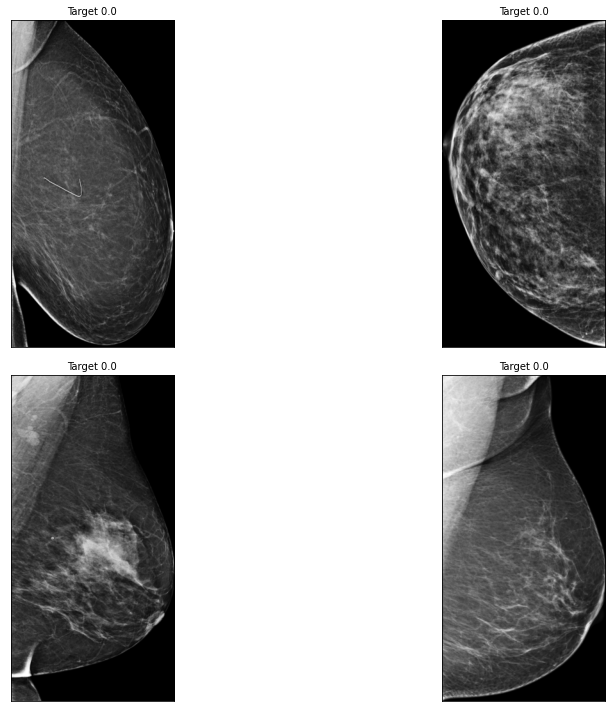

In [28]:
train_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    resize_aspect_ratio = Config.resize_aspect_ratio,
    # img_folder = "/kaggle/input/rsna-breast-png-roi/train_images/256/",
    #img_folder = "/kaggle/input/rsna-cut-off-empty-space-from-images",
    transform=train_augments
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.train_bs,
    shuffle=True,
    num_workers=1,
    collate_fn=mixed_collate_imgs_fn
)
minibatch = next(iter(train_loader))
print(minibatch[0].shape)
print(minibatch[0].mean((1,2,3)))
print(minibatch[0].min())
print(minibatch[0].max())
minibatch[0] += 1.0
minibatch[0] /= 2.0
print(minibatch[0].mean((1,2,3)))

display_batch(minibatch, maximgs=4)

In [29]:
x_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    # img_folder = "/kaggle/input/rsna-breast-png-roi/train_images/256/",
    #img_folder = "/kaggle/input/rsna-cut-off-empty-space-from-images",
    transform=ToTensorV2(),
    return_filepath=True
)

weighted_x_loader = DataLoader(
    x_dataset,
    batch_size=Config.train_bs,
    sampler=torch.utils.data.sampler.WeightedRandomSampler(
        class_weight(df["cancer"].values, Config.positive_upsample_to_percent),
        len(df),
        replacement=False),
    num_workers=Config.dataloader_workers_count,
    collate_fn=mixed_collate_imgs_fn,
)

#if Config.debug or True:
#    for minibatch in weighted_x_loader:
#        imgs = minibatch[0]
#        if torch.isnan(minibatch[0]).sum() > 0:
#            raise ValueError("bad pixel values")
#        if torch.isnan(minibatch[1]).sum() > 0:
#            raise ValueError("bad targets values")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

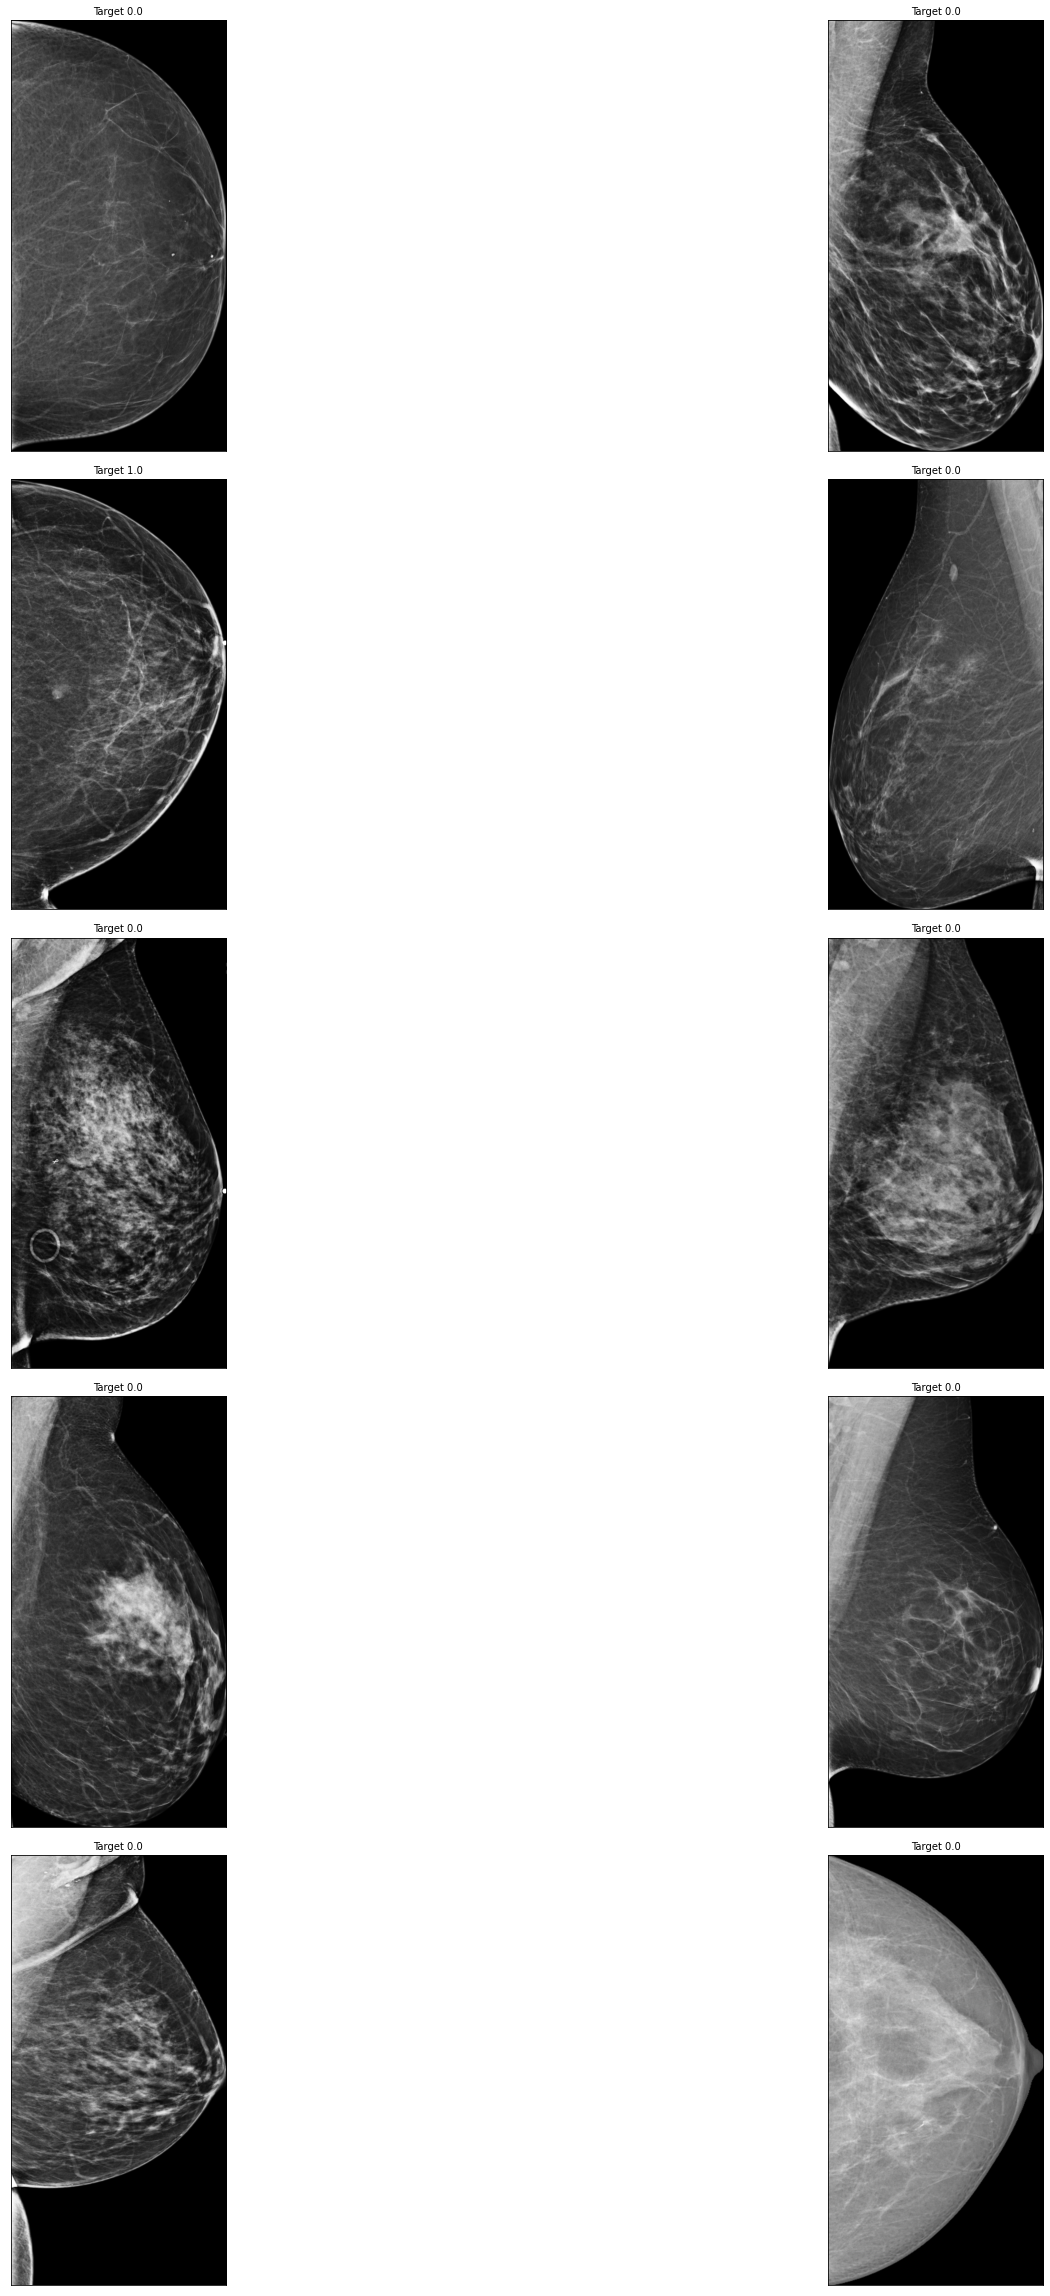

In [30]:
minibatch = next(iter(weighted_x_loader))
display_batch(minibatch, maximgs=10,figsize=(32,32))
minibatch[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

torch.Size([16, 3, 1024, 512])
tensor([-0.3895, -0.5196, -0.6509, -0.6443, -0.5281, -0.5993, -0.5694, -0.4707,
        -0.6246, -0.5693, -0.1485, -0.5395, -0.6201, -0.6407, -0.4508, -0.5396])
tensor(-1.)
tensor(1.)
tensor(0)
tensor([0.3052, 0.2402, 0.1745, 0.1779, 0.2360, 0.2004, 0.2153, 0.2646, 0.1877,
        0.2154, 0.4257, 0.2303, 0.1899, 0.1796, 0.2746, 0.2302])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

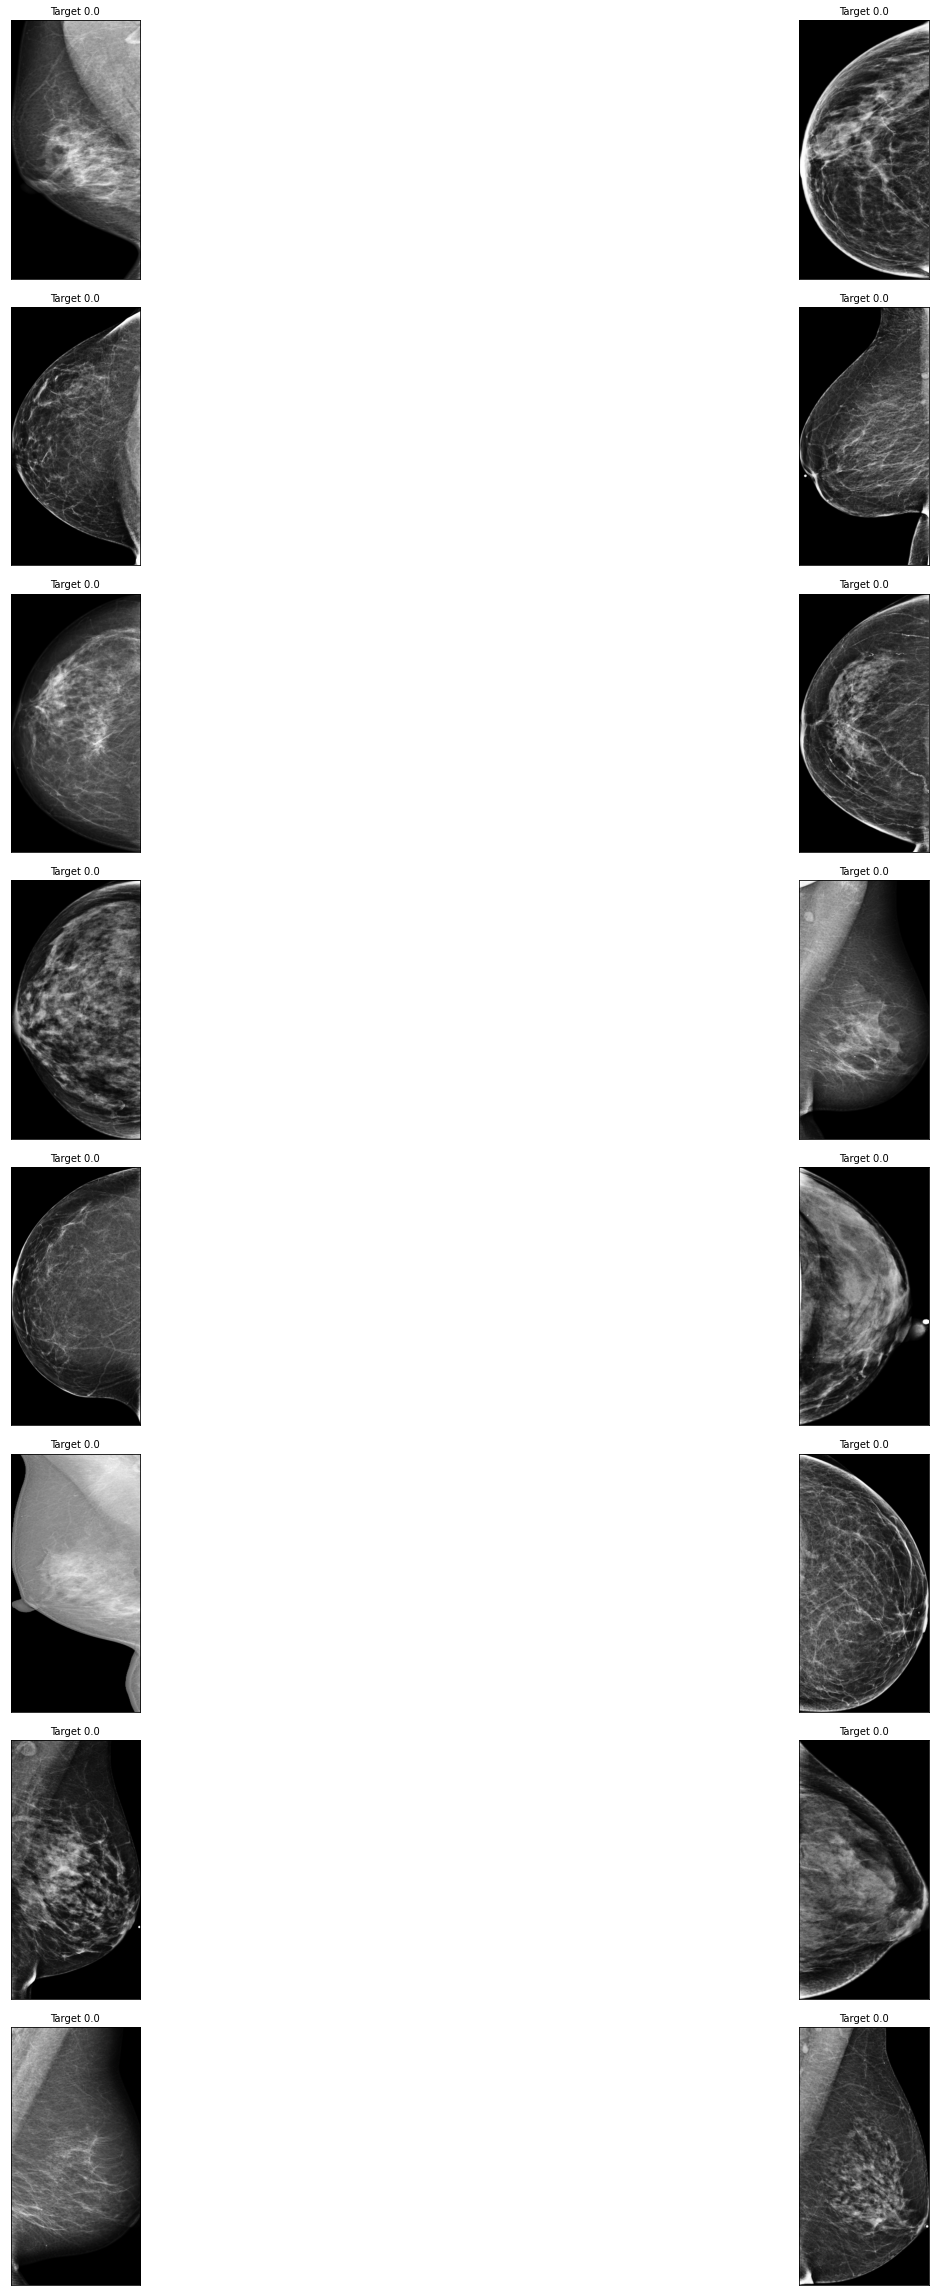

In [31]:
v_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    transform = valid_augments
)
v_loader = DataLoader(
    v_dataset,
    batch_size=Config.train_bs,
    shuffle=False,
    num_workers=Config.dataloader_workers_count,
    collate_fn=mixed_collate_imgs_fn,
    pin_memory=True
)
minibatch = next(iter(v_loader))
print(minibatch[0].shape)
print(minibatch[0].mean((1,2,3)))
print(minibatch[0].min())
print(minibatch[0].max())
print(torch.isnan(minibatch[0]).sum())
minibatch[0] += 1.0
minibatch[0] /= 2.0
print(minibatch[0].mean((1,2,3)))
    
display_batch(minibatch, maximgs=20,figsize=(32,32))

minibatch[1]


In [32]:
%reload_ext tensorboard
%tensorboard --logdir=tb_logs/